# Modelling count data with Tensoflow Probability

In this notebook you will work with TFP. You will set up regression models that are able to output different conditional probability distributions to model count data. You will define different models with Keras, sklearn and the Tensorflow probability framework and optimize the negative log likelihood (NLL).
You compare the performace of the Poisson regression vs. the linear regression on a test dataset.

**Dataset:** 
You work with a camper dataset form https://stats.idre.ucla.edu/r/dae/zip/. The dataset contains data on 250 groups that went to a park. Each group was questioned about how many fish they caught (count), how many children were in the group (child), how many people were in the group (persons), if they used a live bait  and whether or not they brought a camper to the park (camper).
You split the data into train and test dataset.

**Content:**
* Work with different distributions in TFP: Normal and Poisson
* Load and split the camper dataset 
* Fit different regression models to the camper train dataset: linar regression and Poisson regression 
* Plot the predicted probability distributions (CPD) for two specific datapoints along with their likelihood
* Plot the testdata along with the predicted mean and the 2.5% and 97.5% percentiles of the predicted CPD
* Compare the different models based on the test NLL 



In [1]:
%tensorflow_version 2.x

In [2]:
#!pip install tensorflow_probability==0.8.0

#### Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp
import tensorflow as tf

%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.12.1
TF  Version 2.4.1


### Working with a TFP Poisson distribution

Here you can see a small example how to work with a Poisson distribution in TFP. The Poisson distribution has only one parameter, often called $\lambda$ or rate, which defines the mean and the variance of the distribution. We set the rate $\lambda$ to 2, and plot the probability distribution for the values 0 to 10. Below in the notebook you will define a model to learn this parameter.



2.0
1.4142135


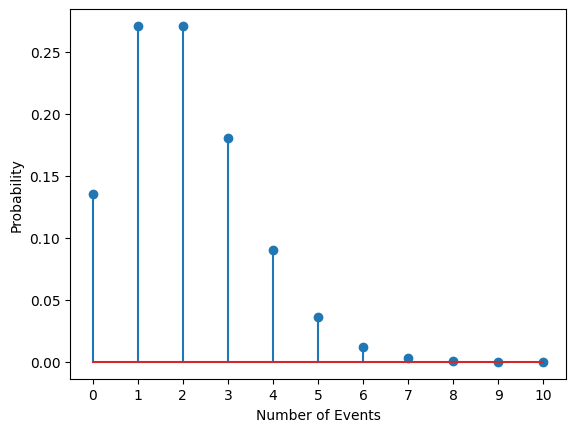

In [4]:
dist = tfd.poisson.Poisson(rate = 2) #A
vals = np.linspace(0,10,11) #B
p = dist.prob(vals) #C
print(dist.mean().numpy())  #D
print(dist.stddev().numpy())   #E

plt.xticks(vals)
plt.stem(vals, p,use_line_collection=True)
plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.show()

#A Poisson distribution with parameter rate = 2
#B Integer values from 0 to 10 for the x-axis 
#C Computes the probability for the values
#D The mean value yielding 2.0
#E The standard deviation yielding sqrt(2.0) = 1.41...


### Loading real count data

Here you load the camper data from: https://stats.idre.ucla.edu/r/dae/zip/. The traget variable is the number of fish caught, during a state park visit by a group. You have data of 250 groups that went to the park. Each group was questioned about how many fish they caught (count), how many children were in the group (child), how many people were in the group (persons), if they used a live bait (livebait) and whether or not they brought a camper to the park (camper). This will be the features.
You randomly split the data into train and test dataset (80% train and 20% test).

In [5]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
dat = np.loadtxt('https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/fish.csv',delimiter=',', skiprows=1)
X = dat[...,1:5] #"livebait","camper","persons","child
y = dat[...,7]
X=np.array(X,dtype="float32")
y=np.array(y,dtype="float32")

Let's split the data and look at the counts (how many fish each group caught).


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)
d = X_train.shape[1]
print(X_train.shape, y_train.shape) 
print(X_test.shape, y_test.shape) 

(200, 4) (200,)
(50, 4) (50,)


In [7]:
print(y_test[0:10], y_train[0:10])

[0. 0. 2. 2. 0. 0. 0. 0. 1. 0.] [ 6.  1.  6.  1.  3.  1.  0. 15.  0.  2.]


In the following we will look at the number of fish each group caught. 

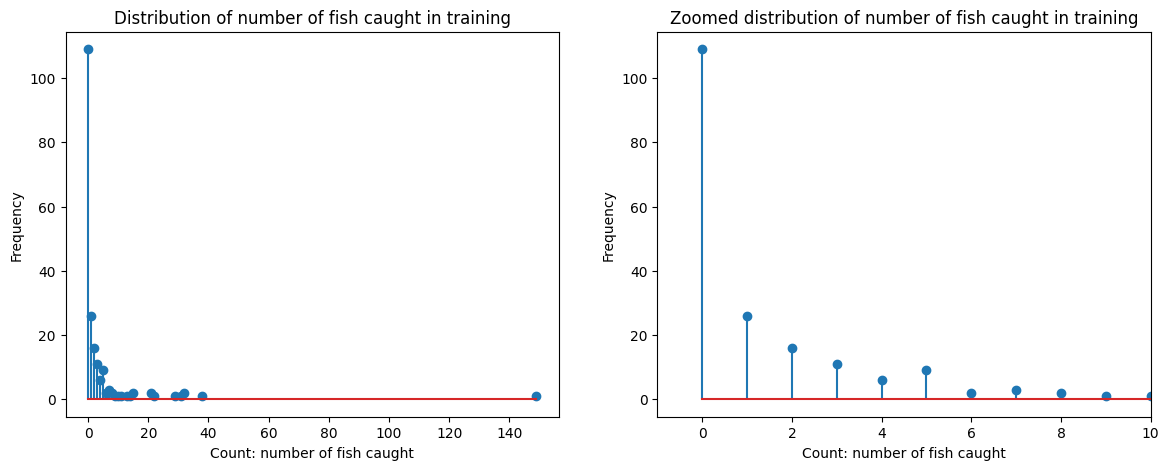

149.0

In [8]:
plt.figure(figsize=(14,5))

vals, counts = np.unique(y_train, return_counts=True)
plt.subplot(1,2,1)
plt.stem(vals, counts,use_line_collection=True)
plt.xlabel('Count: number of fish caught')
plt.ylabel('Frequency')
plt.title('Distribution of number of fish caught in training')

plt.subplot(1,2,2)
plt.stem(vals, counts,use_line_collection=True)
plt.xlabel('Count: number of fish caught')
plt.ylabel('Frequency')
plt.xlim(-1,10)
plt.title('Zoomed distribution of number of fish caught in training')
plt.show()

np.max(y_train)

You see that most of the groups didn't catch any fish at all. Most of the groups were not very successful, but there is one group that was very successful and caught 149 fish!

Lets pick the two test observations 31 and 33, which you will investigate in the following. 

In [9]:
print(X_test[31])#"livebait","camper","persons","child
print(X_test[33])#"livebait","camper","persons","child
print(y_test[31])#"number of caught fish
print(y_test[33])#"number of caught fish

[1. 1. 4. 1.]
[1. 0. 4. 2.]
5.0
0.0


Group 31 used livebait, had a camper and were 4 persons with one child. They caught 5 fish.  
Group 33 used livebait, didn't have a camper and were 4 persons with two childern. They caught 0 fish.

## Linear regression with constant variance

In the next few cells you will ignore the fact that you are dealing with count data here and just fit a linear regression model with constant variance to the data. You will fist do this with sklearn and then with keras. You will use the standart MSE loss and calculate the optimal standart deviation to minimize the NLL. Finally, you predict the test data and compare the performance with the RSME, MAE and the NLL. 

### Linear regression with sklearn 
 
Let's fist fit the linear regression with sklean on the training data.

In [10]:
# The linear regression using non deep learning methods
from sklearn.linear_model import LinearRegression
model_skl = LinearRegression()
res = model_skl.fit(X_train, y_train)

In linear regression, we assuming that the $\sigma$ is constant. To calculate the NLL, we need to estimate this quantity from the training data. The prediction is of course done on the testdata. Note that we calculate the mean  test NLL.

In [11]:
import pandas as pd
# Calculation of the the optimal sigma 
y_hat_train = model_skl.predict(X_train)
n = len(y_hat_train)
sigma_hat_2 = (n-1.)/(n-2.) * np.var(y_train - y_hat_train.flatten(),ddof=1)
print('Estimated variance ', sigma_hat_2)
print('Estimated standart deviation ', np.sqrt(sigma_hat_2))

y_hat = model_skl.predict(X_test) #Prediction on the testset
RMSE_skl = np.sqrt(np.mean((y_test - y_hat.flatten())**2))
MAE_skl = np.mean(np.abs(y_test- y_hat.flatten())) 

NLL_skl =  0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_test - y_hat.flatten())**2)/sigma_hat_2
print('NLL on training:', 0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_train - y_hat_train.flatten())**2)/sigma_hat_2)

df1 = pd.DataFrame(
          {'RMSE' : RMSE_skl, 'MAE' : MAE_skl, 'NLL (mean)' : NLL_skl}, index=['Linear Regression (sklearn)']
)
df1

Estimated variance  118.45403393832119
Estimated standart deviation  10.883659032619553
NLL on training: 3.801201024145479


,RMSE,MAE,NLL (mean)
Linear Regression (sklearn),8.588127,4.705091,3.617528


### Linear regression with Keras 
 
Let's do the same as before with sklearn, but this time you fit a linear regression  model with keras.
You have 4 inputs (child , persons livebait, camper) and 1 output (count). Note that you'll use the standart MSE loss.

In [12]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input 
from tensorflow.keras.optimizers import Adam

model_lr = Sequential() 
model_lr.add(Dense(1,input_dim=d, activation='linear')) 
model_lr.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.01))

In [13]:
hist_lr = model_lr.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=5000, verbose=0, batch_size=len(y_train))

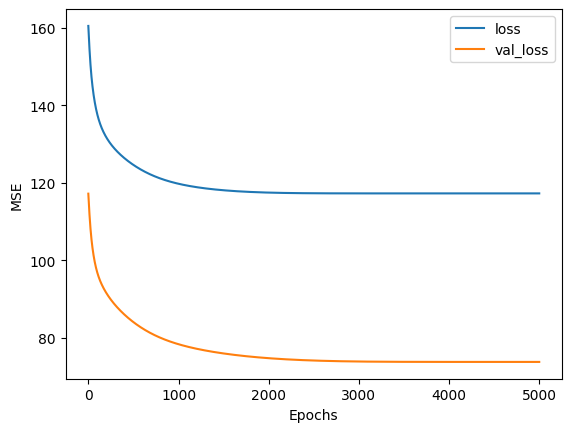

In [14]:
plt.plot(hist_lr.history['loss']) #Note this is the MSE and not the RMSE
plt.plot(hist_lr.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

#### Evaluation of the Performance 


In [15]:
# Calculation of the the optimal sigma 
y_hat_train = model_lr.predict(X_train)
sigma_hat_2 = (n-1.)/(n-2.) * np.var(y_train - y_hat_train.flatten(),ddof=1)
print('Estimated variance ', sigma_hat_2)
print('Estimated standart deviation ', np.sqrt(sigma_hat_2))

y_hat = model_lr.predict(X_test) #Prediction on the testset
RMSE_lr = np.sqrt(np.mean((y_test - y_hat.flatten())**2))
MAE_lr = np.mean(np.abs(y_test - y_hat.flatten())) 

NLL_lr =  0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_test - y_hat.flatten())**2)/sigma_hat_2
print('NLL on training:', 0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_train - y_hat_train.flatten())**2)/sigma_hat_2)

df2 = pd.DataFrame(
          {'RMSE' : RMSE_lr, 'MAE' : MAE_lr, 'NLL (mean)' : NLL_lr}, index=['Linear Regression (MSE Keras)']
)
pd.concat([df1,df2])

Estimated variance  118.4540109345407
Estimated standart deviation  10.883657975815884
NLL on training: 3.8012009265623785


,RMSE,MAE,NLL (mean)
Linear Regression (sklearn),8.588127,4.705091,3.617528
Linear Regression (MSE Keras),8.588128,4.705087,3.617528


In the pandas dataframe above you see that the RMSE, MAE and the NLL are same. In the next cell you are comparing the coefficients of the keras and sklearn linear regression models. As you can see you get the same results! 

In [16]:
print('weights using deep learning:          ',model_lr.get_weights()[0][:,0])
print('weights from sklearn:                 ',res.coef_)
print('Intercept (bias) using deep learning: ',model_lr.get_weights()[1][0])
print('Intercept (bias) using sklearn:       ',res.intercept_)

weights using deep learning:           [ 2.482188   2.954299   4.649524  -5.4715924]
weights from sklearn:                  [ 2.4822128  2.9543095  4.6495404 -5.4716005]
Intercept (bias) using deep learning:  -8.492166
Intercept (bias) using sklearn:        -8.492231


Let's plot the observed values vs the predicted mean of caught fish on the test dataset. To inicate the CPD you also plot  the 2.5% and 97.5% percentiles of the predicted CPD. You highlight the observations 31 and 33.

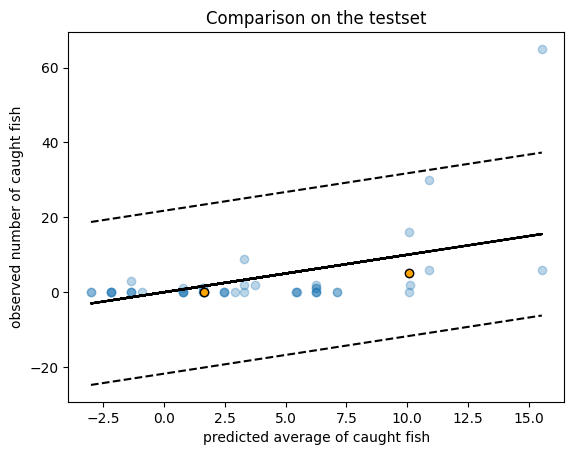

In [17]:
y_hat_test=model_lr.predict(X_test)
plt.scatter(y_hat_test, y_test,alpha=0.3)
plt.scatter(y_hat_test[33], y_test[33],c="orange",marker='o',edgecolors= "black")
plt.scatter(y_hat_test[31], y_test[31],c="orange",marker='o',edgecolors= "black")
sort_idx=np.argsort(y_hat_test,axis=0)
plt.plot(y_hat_test[sort_idx].flatten(), y_hat_test[sort_idx].flatten()+2*np.sqrt(sigma_hat_2),linestyle='dashed',c="black")
plt.plot(y_hat_test[sort_idx].flatten(), y_hat_test[sort_idx].flatten()-2*np.sqrt(sigma_hat_2),linestyle='dashed',c="black")
plt.plot(y_hat_test, y_hat_test, c="black")
plt.title('Comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')
plt.show()

In [18]:
# Let's check the mean of the predicted CPDs for the obeservations nr 31 and 33
print(y_hat_test[31])
print(y_hat_test[33])
# Remember the observed nr of caught fish for the obeservations nr 31 and 33
print(y_test[31])
print(y_test[33])

[10.070827]
[1.6449337]
5.0
0.0


Lets check the predicted outcome distribution for the observations 31 and 33.

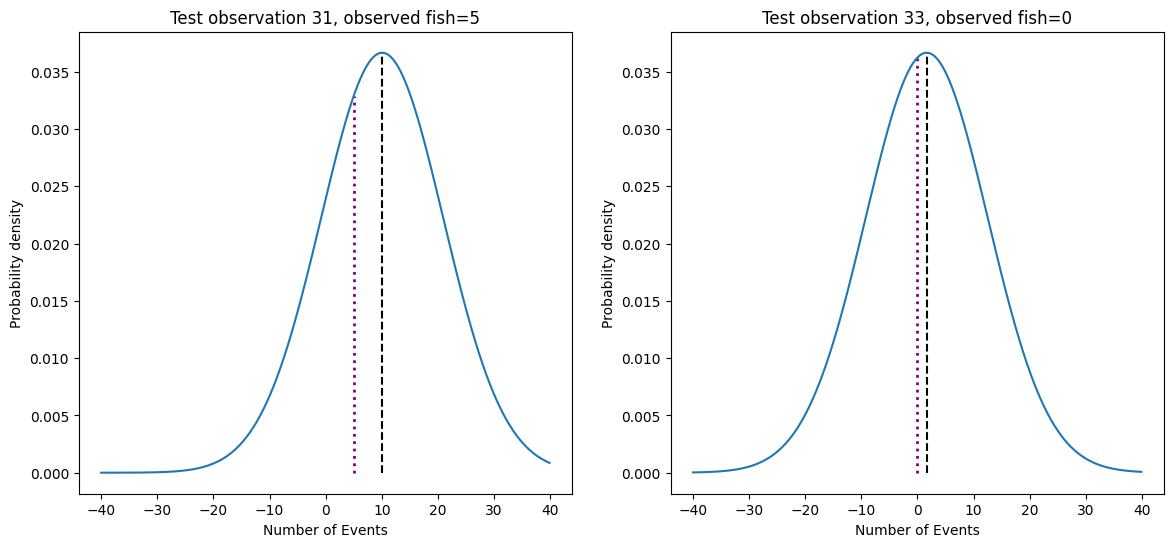

In [19]:
dist = tfd.Normal(loc=y_hat_test,scale=np.sqrt(sigma_hat_2,dtype="float32"))
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(np.arange(-40,40,0.1),dist.prob(np.arange(-40,40,0.1))[31])
plt.vlines(y_hat_test[31], ymin=0, ymax=dist.prob(y_hat_test)[31],linestyle='dashed')
plt.vlines(np.expand_dims(y_test,axis=1)[31], ymin=0, ymax=dist.prob(np.expand_dims(y_test,axis=1))[31],linestyle='dotted',color="purple",linewidth=2)
plt.xlabel('Number of Events')
plt.ylabel('Probability density')
plt.title('Test observation 31, observed fish=5')

plt.subplot(1,2,2)
plt.plot(np.arange(-40,40,0.1),dist.prob(np.arange(-40,40,0.1))[33])
plt.vlines(y_hat_test[33], ymin=0, ymax=dist.prob(y_hat_test)[33],linestyle='dashed')
plt.vlines(np.expand_dims(y_test,axis=1)[33], ymin=0, ymax=dist.prob(np.expand_dims(y_test,axis=1))[33],linestyle='dotted',color="purple",linewidth=2)
plt.xlabel('Number of Events')
plt.ylabel('Probability density')
plt.title('Test observation 33, observed fish=0')
plt.show()

You can see that the liklihood of the observed values are quite high under the predicted CPDs (dotted line). However, note that the linear model predicts also negative values, which is obviously wrong. 

## Poisson Regression 

Now you use  the TFP framework and the Poission distribution to model the output of the network as a Poissonian CPD. You will not use any hidden layers in between and the loss will be the NLL. After the fitting, you predict the test data and compare the performance with the linear regression model.
$$
    Y \thicksim \tt{Pois}(exp(w^{T} \cdot x + b))
$$



In [20]:
inputs = Input(shape=(X_train.shape[1],))  
rate = Dense(1, 
         activation=tf.exp)(inputs) #A
p_y = tfp.layers.DistributionLambda(tfd.Poisson)(rate) #B 

model_p = Model(inputs=inputs, outputs=p_y) #C


def NLL(y_true, y_hat): #D
  return -y_hat.log_prob(y_true)

model_p.compile(Adam(learning_rate=0.01), loss=NLL)
model_p.summary()

#A Definition of a single layer with one output
#B We use exponential of the output to model the rate
#C Glueing the NN and the output layer together. Note that output p_y is a tf.distribution
#D The second argument is the output of the model and thus a tfp-distribution. It's as simple as calling log_prob to calculate the log-probability of the observation that is needed to calculate the NLL.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
_________________________________________________________________
distribution_lambda (Distrib multiple                  0         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [21]:
hist_p = model_p.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=2000, verbose=0)

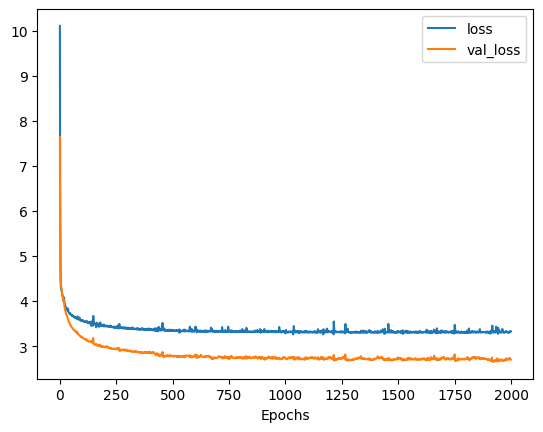

In [22]:
plt.plot(hist_p.history['loss'])
plt.plot(hist_p.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.show()

#### Evaluation of the Performance 


In [30]:
#model = Model(inputs=inputs, outputs=p_y.mean()) 
#y_hat_test = model.predict(X_test).flatten()

#New API
y_hat_test_dist = model_p(X_test)
y_hat_test = y_hat_test_dist.mean().numpy().flatten()

#### Exercise:
Calculate the rmse (root mean square error), the mae (mean absolute error) and the NLL (negative log likelihood) of the Poisson regression model and compare the result to the normal distribution regression model.  
What do you observe?  
Which model would you choose?

In [ ]:
### your code here 

rmse=
mae= 

NLL = 

df3 = pd.DataFrame(
         { 'RMSE' : rmse, 'MAE' : mae, 'NLL (mean)' : NLL}, index=['Poisson Regression (TFP)']
)
pd.concat([df1,df2,df3])

In the pandas dataframe above you see that the RMSE, MAE and the NLL of the diferent models. You see that the Poisson regression outperform the linear regression because of the lower NLL.

Let's plot the observed values vs the predicted mean of caught fish on the test dataset. To inicate the CPD you also plot  the 2.5% and 97.5% percentiles of the predicted CPD. You highlight the observations 31 and 33.

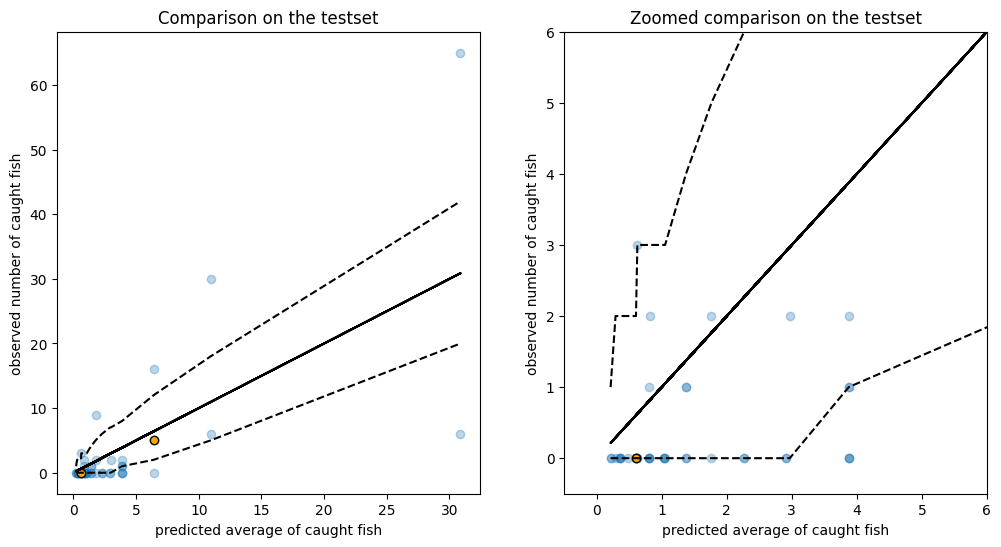

In [31]:
from scipy.stats import poisson
lower=poisson.ppf(0.025, y_hat_test) #ppf(q, mu, loc=0) Percent point function (inverse of cdf — percentiles) 
upper=poisson.ppf(0.975, y_hat_test) #ppf(q, mu, loc=0) Percent point function (inverse of cdf — percentiles)

#lower=np.percentile(dist.sample(100000),2.5,axis=0)
#upper=np.percentile(dist.sample(100000),97.5,axis=0)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.scatter(y_hat_test[33], y_test[33],c="orange",marker='o',edgecolors= "black")
plt.scatter(y_hat_test[31], y_test[31],c="orange",marker='o',edgecolors= "black")
plt.title('Comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), lower[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), upper[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test, y_hat_test, c="black")


plt.subplot(1,2,2)
plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.scatter(y_hat_test[33], y_test[33],c="orange",marker='o',edgecolors= "black")
plt.scatter(y_hat_test[31], y_test[31],c="orange",marker='o',edgecolors= "black")
plt.title('Zoomed comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), lower[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), upper[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test, y_hat_test, c="black")
plt.xlim([-0.5,6])
plt.ylim([-0.5,6])
plt.show()

In [32]:
# Let's check the mean of the predicted CPDs for the obeservations nr 31 and 33
print(y_hat_test[31])
print(y_hat_test[33])
# Remember the observed nr of caught fish for the obeservations nr 31 and 33
print(y_test[31])
print(y_test[33])

6.3995314
0.60407513
5.0
0.0


Lets check the predicted outcome distribution for the observations 31 and 33.

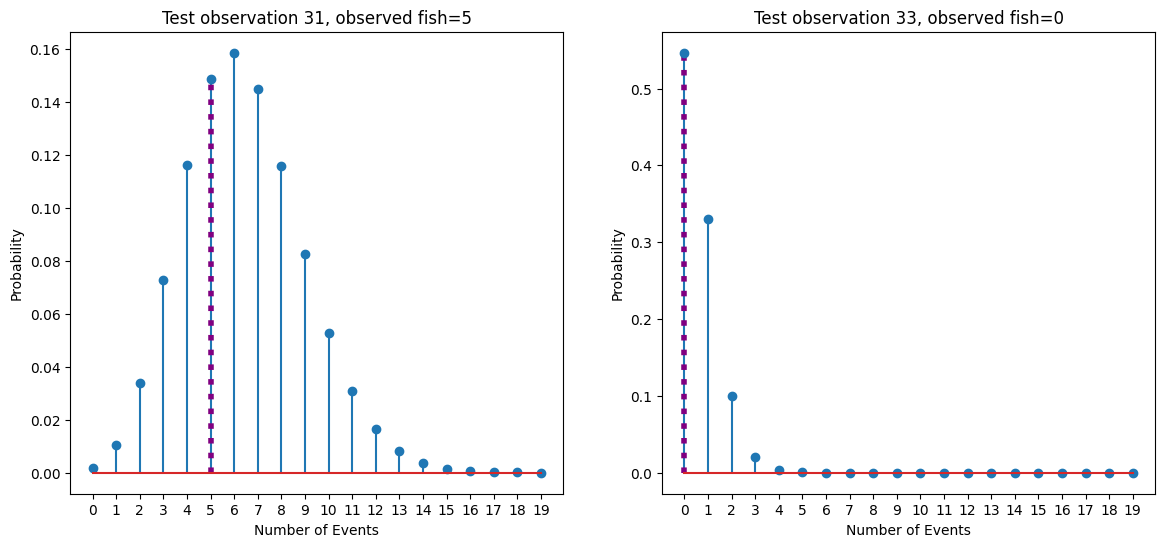

In [33]:
probs=model_p(X_test).prob(np.arange(0,20,1)).numpy()
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.stem(np.arange(0,20,1),probs[31,:],use_line_collection=True)
plt.xticks(np.arange(0,20,1))
plt.vlines(np.expand_dims(y_test,axis=1)[31], ymin=0, ymax=probs[31,np.int(y_test[31])],linestyle='dotted',color="purple",linewidth=4)

plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.title('Test observation 31, observed fish=5')

plt.subplot(1,2,2)
plt.stem(np.arange(0,20,1),probs[33,:],use_line_collection=True)
plt.xticks(np.arange(0,20,1))
plt.vlines(np.expand_dims(y_test,axis=1)[33], ymin=0, ymax=probs[33,np.int(y_test[33])],linestyle='dotted',color="purple",linewidth=4)
plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.title('Test observation 33, observed fish=0')
plt.show()

You can see that the liklihood of the observed values are quite high under the predicted CPDs (dotted line). Note that the Poisson CPD does only predict non-negative integer values which is a quite nice property for count data.


 